# Gradient Boosting Decision Trees (GBDT) for Flight Delay Prediction

This notebook implements gradient boosting models for flight delay prediction using the preprocessed data created in the `02_ml_preprocessing.ipynb` pipeline. We'll use the gradient boosting optimized dataset specifically engineered for tree-based models.

## Objectives
1. Load the preprocessed data optimized for gradient boosting models
2. Explore and understand the key features
3. Train multiple gradient boosting models (LightGBM, XGBoost, CatBoost)
4. Tune hyperparameters for optimal performance
5. Evaluate model performance using relevant metrics
6. Create an ensemble of the best-performing models
7. Save the trained models for deployment

The models built in this notebook will leverage the specialized preprocessing steps applied in the gradient boosting pipeline, including preserved missing values, specialized categorical encodings, and advanced feature engineering.

In [ ]:
# Import required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
import warnings

# For gradient boosting models
import lightgbm as lgb
import xgboost as xgb
try:
    import catboost as cb
    catboost_available = True
except ImportError:
    print("CatBoost not installed. Will skip CatBoost implementation.")
    catboost_available = False

# Ignore warnings
warnings.filterwarnings('ignore')

# Configure paths dynamically using relative paths
import os.path as path

# Get the directory of the current notebook
notebook_dir = path.dirname(path.abspath('__file__'))
# Get project root (parent of notebooks directory)
project_root = path.abspath(path.join(notebook_dir, '..', '..'))

# Define paths relative to project root
GB_PROCESSED_PATH = path.join(project_root, 'data', 'processed', 'ml_ready_flights', 'gb_ready_flights.csv')
LIGHTGBM_CATS_PATH = path.join(project_root, 'data', 'processed', 'ml_ready_flights', 'gb_ready_flights_lightgbm_cats.json')
MODELS_PATH = path.join(project_root, 'models', 'machine_learning')

# Create directories if they don't exist
os.makedirs(MODELS_PATH, exist_ok=True)

# Print paths for reference
print(f"Gradient Boosting dataset path: {GB_PROCESSED_PATH}")
print(f"LightGBM categorical mapping path: {LIGHTGBM_CATS_PATH}")
print(f"Models will be saved to: {MODELS_PATH}")

# Display settings
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)
print("Libraries and paths configured.")

## Models Implemented

This notebook implements multiple gradient boosting decision tree (GBDT) models for flight delay prediction:

### 1. LightGBM
LightGBM is a highly efficient gradient boosting framework developed by Microsoft. Key characteristics:
- Uses a histogram-based approach for finding optimal splits
- Leaf-wise tree growth strategy for better accuracy
- Native handling of categorical features
- Excellent performance on large datasets
- Faster training speeds compared to other GBDT implementations

### 2. XGBoost
XGBoost (eXtreme Gradient Boosting) is a popular and powerful implementation of gradient boosting. Key characteristics:
- Second-order gradient optimization
- Built-in regularization to prevent overfitting
- Highly parallelized computation
- Supports both regression and classification tasks
- Robust handling of missing values

### 3. Ensemble Model
This notebook also creates an ensemble of the above models by averaging their predictions. Ensemble methods combine multiple models to achieve better predictive performance than any individual model. Benefits include:
- Reduced variance (error) in predictions
- Better generalization to unseen data
- More robust predictions across different flight conditions
- Mitigation of individual model weaknesses

Each model is trained on time-series split data to ensure proper temporal evaluation, and performance is measured using standard regression metrics (RMSE, MAE, R²).

In [ ]:
# Function to load data in chunks to handle large datasets
def load_processed_data(file_path, chunk_size=500000, max_chunks=None):
    """
    Load preprocessed data in chunks and combine into a single DataFrame
    
    Parameters:
    -----------
    file_path : str
        Path to the processed data file
    chunk_size : int
        Number of rows to read at once
    max_chunks : int or None
        Maximum number of chunks to read (useful for development/testing)
        If None, read all chunks
        
    Returns:
    --------
    pandas.DataFrame
        Combined DataFrame with all loaded data
    """
    chunks = []
    
    for i, chunk in enumerate(pd.read_csv(file_path, chunksize=chunk_size)):
        # Stop after max_chunks if specified
        if max_chunks is not None and i >= max_chunks:
            break
        
        # Convert date columns to datetime
        date_columns = [col for col in chunk.columns if 'DATE' in col.upper()]
        for col in date_columns:
            chunk[col] = pd.to_datetime(chunk[col], errors='coerce')
        
        chunks.append(chunk)
        print(f"Loaded chunk {i+1} with shape: {chunk.shape}")
    
    # Combine all chunks
    combined_data = pd.concat(chunks, ignore_index=True)
    
    return combined_data

In [3]:
# Load the gradient boosting optimized data
# For initial exploration, load a smaller subset (adjust max_chunks as needed)
gb_data = load_processed_data(GB_PROCESSED_PATH, max_chunks=2)

print(f"\nLoaded data shape: {gb_data.shape}")
print("\nColumns and data types:")
for col in gb_data.columns:
    print(f"- {col}: {gb_data[col].dtype}")

print("\nSample data (first 5 rows):")
display(gb_data.head())

Loaded chunk 2 with shape: (500000, 91)

Loaded data shape: (1000000, 91)

Columns and data types:
- FL_DATE: datetime64[ns]
- AIRLINE: object
- AIRLINE_DOT: object
- AIRLINE_CODE: object
- DOT_CODE: int64
- FL_NUMBER: int64
- ORIGIN: object
- ORIGIN_CITY: object
- DEST: object
- DEST_CITY: object
- CRS_DEP_TIME: int64
- DEP_TIME: int64
- DEP_DELAY: float64
- TAXI_OUT: float64
- WHEELS_OFF: float64
- WHEELS_ON: float64
- TAXI_IN: float64
- CRS_ARR_TIME: int64
- ARR_TIME: float64
- ARR_DELAY: float64
- CANCELLED: int64
- DIVERTED: int64
- CRS_ELAPSED_TIME: float64
- ELAPSED_TIME: float64
- AIR_TIME: float64
- DISTANCE: float64
- YEAR: int64
- QUARTER: int64
- MONTH: int64
- DAY_OF_MONTH: int64
- DAY_OF_WEEK: int64
- SEASON: int64
- IS_HOLIDAY_SEASON: int64
- DEP_HOUR: int64
- TIME_OF_DAY: object
- ROUTE: object
- DISTANCE_GROUP: object
- MONTH_SIN: float64
- MONTH_COS: float64
- DAY_OF_WEEK_SIN: float64
- DAY_OF_WEEK_COS: float64
- DEP_HOUR_SIN: float64
- DEP_HOUR_COS: float64
- DEP_DIF

,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,...,DAY_HOUR_target_mean,MONTH_DAY_encoded,MONTH_DAY_target_mean,ORIGIN_PREV_DAY_DELAY,ATL_MONTH_SIN,ATL_MONTH_COS,DFW_MONTH_SIN,DFW_MONTH_COS,ORD_MONTH_SIN,ORD_MONTH_COS,DEN_MONTH_SIN,DEN_MONTH_COS,CLT_MONTH_SIN,CLT_MONTH_COS,LAX_MONTH_SIN,LAX_MONTH_COS,PHX_MONTH_SIN,PHX_MONTH_COS,LAS_MONTH_SIN,LAS_MONTH_COS,SEA_MONTH_SIN,SEA_MONTH_COS,LGA_MONTH_SIN,LGA_MONTH_COS,DELAY_PER_DISTANCE
0,2019-01-01,American Airlines Inc.,American Airlines Inc.: AA,AA,19805,463,MCO,"Orlando, FL",PHX,"Phoenix, AZ",1228,1236,8.0,16.0,2052.0,2306.0,14.0,1393,2320.0,7.0,0,0,285.0,284.0,254.0,...,17.373422,22,11.718573,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004327
1,2019-01-01,American Airlines Inc.,American Airlines Inc.: AA,AA,19805,2688,MIA,"Miami, FL",SFO,"San Francisco, CA",1089,1082,0.0,17.0,1819.0,2052.0,6.0,1297,2058.0,0.0,0,0,388.0,356.0,333.0,...,16.091433,22,11.718573,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,2019-01-01,Mesa Airlines Inc.,Mesa Airlines Inc.: YV,YV,20378,6207,IAH,"Houston, TX",TUS,"Tucson, AZ",1290,1288,0.0,19.0,2147.0,2310.0,10.0,1404,2320.0,0.0,0,0,174.0,172.0,143.0,...,18.198601,22,11.718573,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,2019-01-01,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,117,SPN,"Saipan, TT",GUM,"Guam, TT",555,525,0.0,20.0,905.0,932.0,3.0,595,935.0,0.0,0,0,40.0,50.0,27.0,...,9.410662,22,11.718573,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,2019-01-01,American Airlines Inc.,American Airlines Inc.: AA,AA,19805,720,TPA,"Tampa, FL",DCA,"Washington, DC",767,765,0.0,14.0,1259.0,1441.0,6.0,900,1447.0,0.0,0,0,133.0,122.0,102.0,...,11.051188,22,11.718573,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [4]:
# Load LightGBM categorical feature mappings
try:
    with open(LIGHTGBM_CATS_PATH, 'r') as f:
        lightgbm_cats = json.load(f)
    
    print(f"Loaded categorical mappings for {len(lightgbm_cats)} features")
    
    # Convert categorical columns to 'category' dtype for LightGBM
    for col in lightgbm_cats.keys():
        if col in gb_data.columns:
            gb_data[col] = gb_data[col].astype('category')
    
except Exception as e:
    print(f"Error loading LightGBM categorical mappings: {e}")
    lightgbm_cats = {}

Loaded categorical mappings for 12 features


## Data Exploration and Preparation

Let's explore the preprocessed data and prepare it for modeling. We'll focus on understanding:
1. The distribution of the target variable (DEP_DELAY)
2. Key features and their importance
3. Missing value patterns (which gradient boosting can handle)
4. Data splitting for training and evaluation

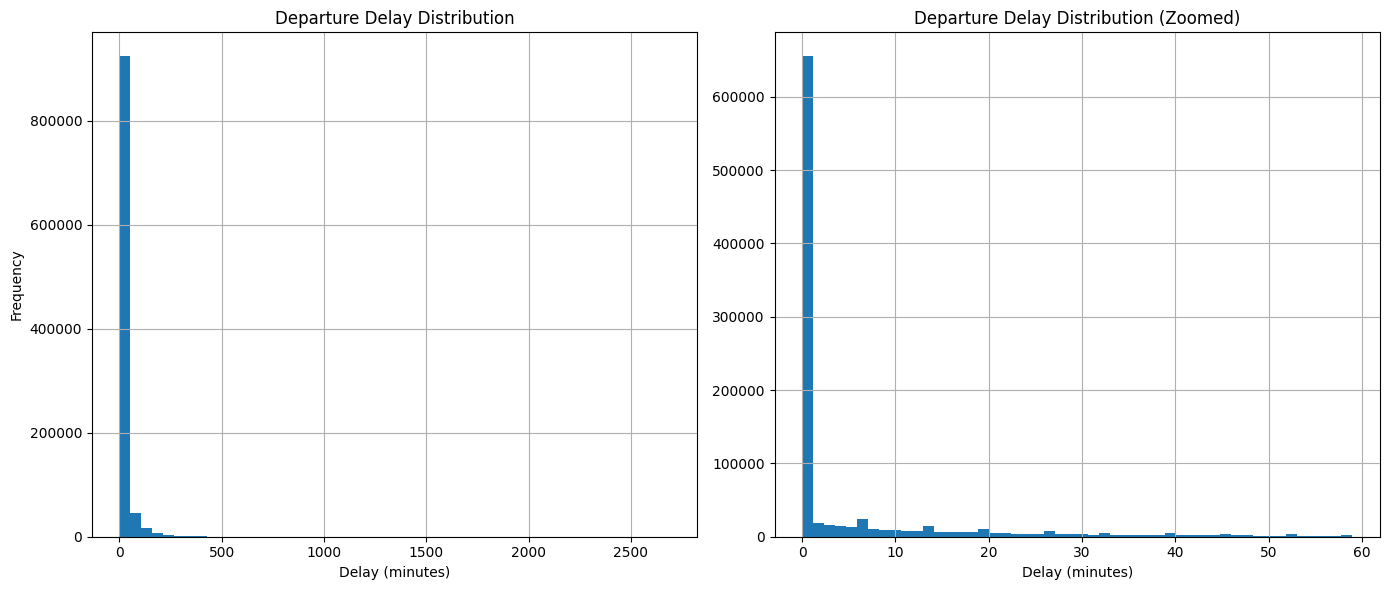


Statistics of DEP_DELAY:
count    1000000.000000
mean          14.626939
std           49.868100
min            0.000000
25%            0.000000
50%            0.000000
75%            8.000000
max         2690.000000
Name: DEP_DELAY, dtype: float64

Flight status percentages:
Early departures: 0.00%
On-time departures: 63.25%
Delayed departures: 36.75%


In [5]:
# Explore target variable distribution
plt.figure(figsize=(14, 6))

plt.subplot(121)
gb_data['DEP_DELAY'].hist(bins=50)
plt.title('Departure Delay Distribution')
plt.xlabel('Delay (minutes)')
plt.ylabel('Frequency')

plt.subplot(122)
# Zoom in on the central part of the distribution (exclude extreme values)
delay_zoomed = gb_data['DEP_DELAY'][(gb_data['DEP_DELAY'] > -30) & (gb_data['DEP_DELAY'] < 60)]
delay_zoomed.hist(bins=50)
plt.title('Departure Delay Distribution (Zoomed)')
plt.xlabel('Delay (minutes)')

plt.tight_layout()
plt.show()

# Basic statistics of the target variable
print("\nStatistics of DEP_DELAY:")
print(gb_data['DEP_DELAY'].describe())

# Calculate percentage of negative delays (early departures) and positive delays
early_pct = (gb_data['DEP_DELAY'] < 0).mean() * 100
on_time_pct = (gb_data['DEP_DELAY'] == 0).mean() * 100
delayed_pct = (gb_data['DEP_DELAY'] > 0).mean() * 100

print(f"\nFlight status percentages:")
print(f"Early departures: {early_pct:.2f}%")
print(f"On-time departures: {on_time_pct:.2f}%")
print(f"Delayed departures: {delayed_pct:.2f}%")

Top categories for each categorical feature:

AIRLINE:
AIRLINE
Southwest Airlines Co.    189142
Delta Air Lines Inc.      134554
American Airlines Inc.    128297
SkyWest Airlines Inc.     112048
United Air Lines Inc.      89193
Name: count, dtype: int64

AIRLINE_DOT:
AIRLINE_DOT
Southwest Airlines Co.: WN    189142
Delta Air Lines Inc.: DL      134554
American Airlines Inc.: AA    128297
SkyWest Airlines Inc.: OO     112048
United Air Lines Inc.: UA      89193
Name: count, dtype: int64

AIRLINE_CODE:
AIRLINE_CODE
WN    189142
DL    134554
AA    128297
OO    112048
UA     89193
Name: count, dtype: int64

ORIGIN:
ORIGIN
ATL    51179
DFW    41883
ORD    40752
DEN    39516
CLT    30891
Name: count, dtype: int64

ORIGIN_CITY:
ORIGIN_CITY
Chicago, IL              52166
Atlanta, GA              51179
Dallas/Fort Worth, TX    41883
Denver, CO               39516
New York, NY             39284
Name: count, dtype: int64
AIRLINE_CODE
WN    189142
DL    134554
AA    128297
OO    112048
UA     8919

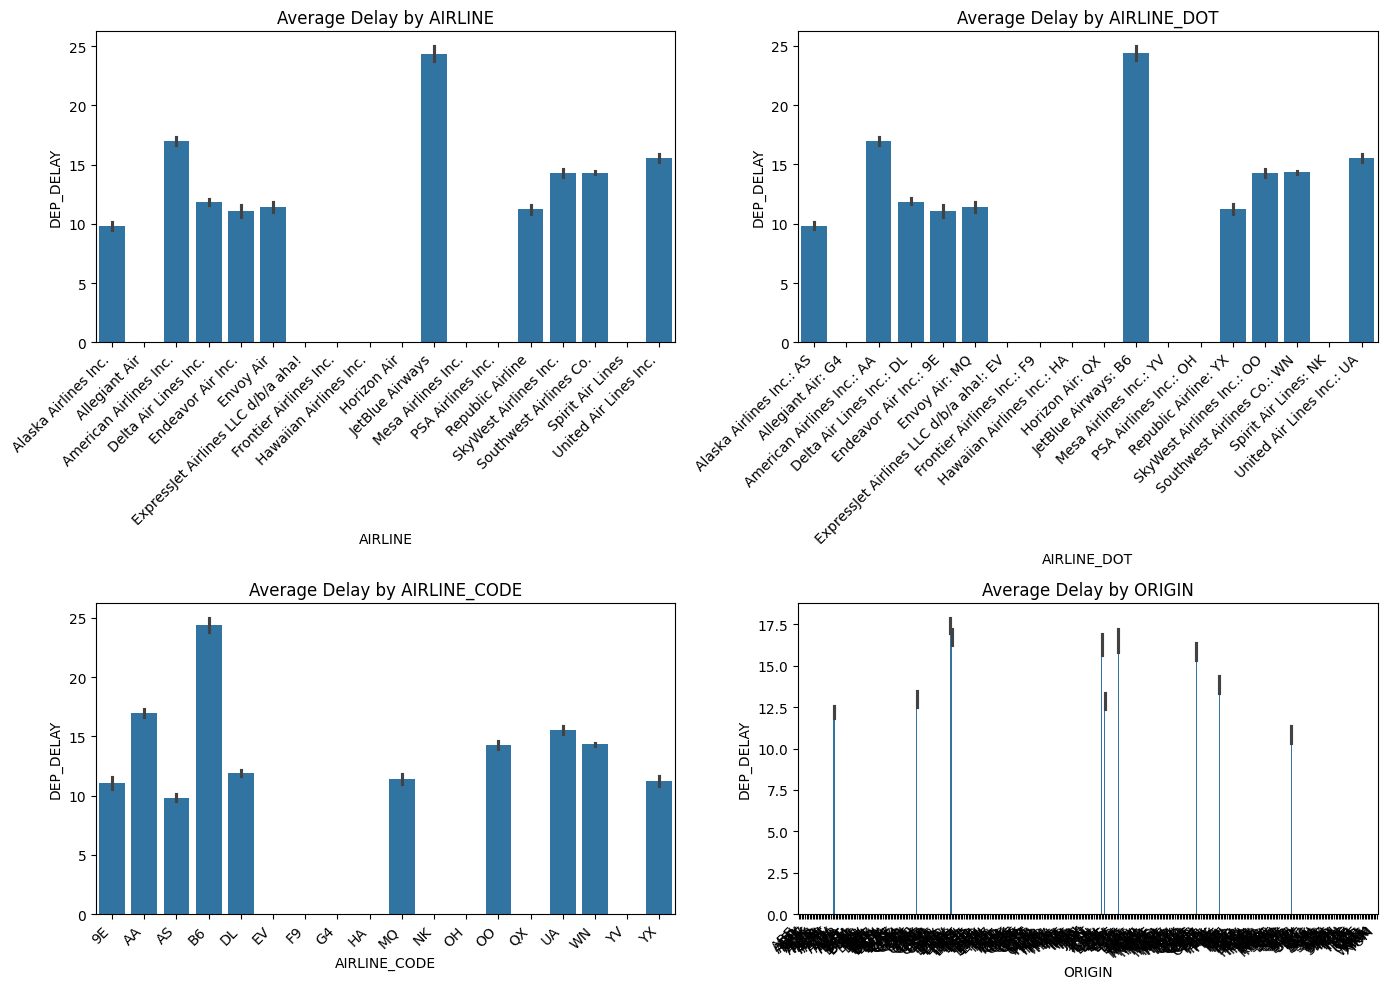

In [6]:
# Explore categorical features
categorical_cols = [col for col in gb_data.columns 
                   if gb_data[col].dtype == 'category' or col in lightgbm_cats.keys()]

# For each categorical column, show value counts for top categories
print("Top categories for each categorical feature:")
for col in categorical_cols[:5]:  # Limit to first 5 to avoid excessive output
    if col in gb_data.columns:
        print(f"\n{col}:")
        print(gb_data[col].value_counts().head(5))

# Explore categorical features' relationship with target
if categorical_cols:
    plt.figure(figsize=(14, 10))
    for i, col in enumerate(categorical_cols[:4]):  # Limit to first 4 for visibility
        if col in gb_data.columns:
            plt.subplot(2, 2, i+1)
            # Select top categories for better visualization
            top_cats = gb_data[col].value_counts().head(10).index
            cat_data = gb_data[gb_data[col].isin(top_cats)]
            
            # Create barplot of average delay by category
            sns.barplot(x=col, y='DEP_DELAY', data=cat_data)
            plt.title(f'Average Delay by {col}')
            plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()

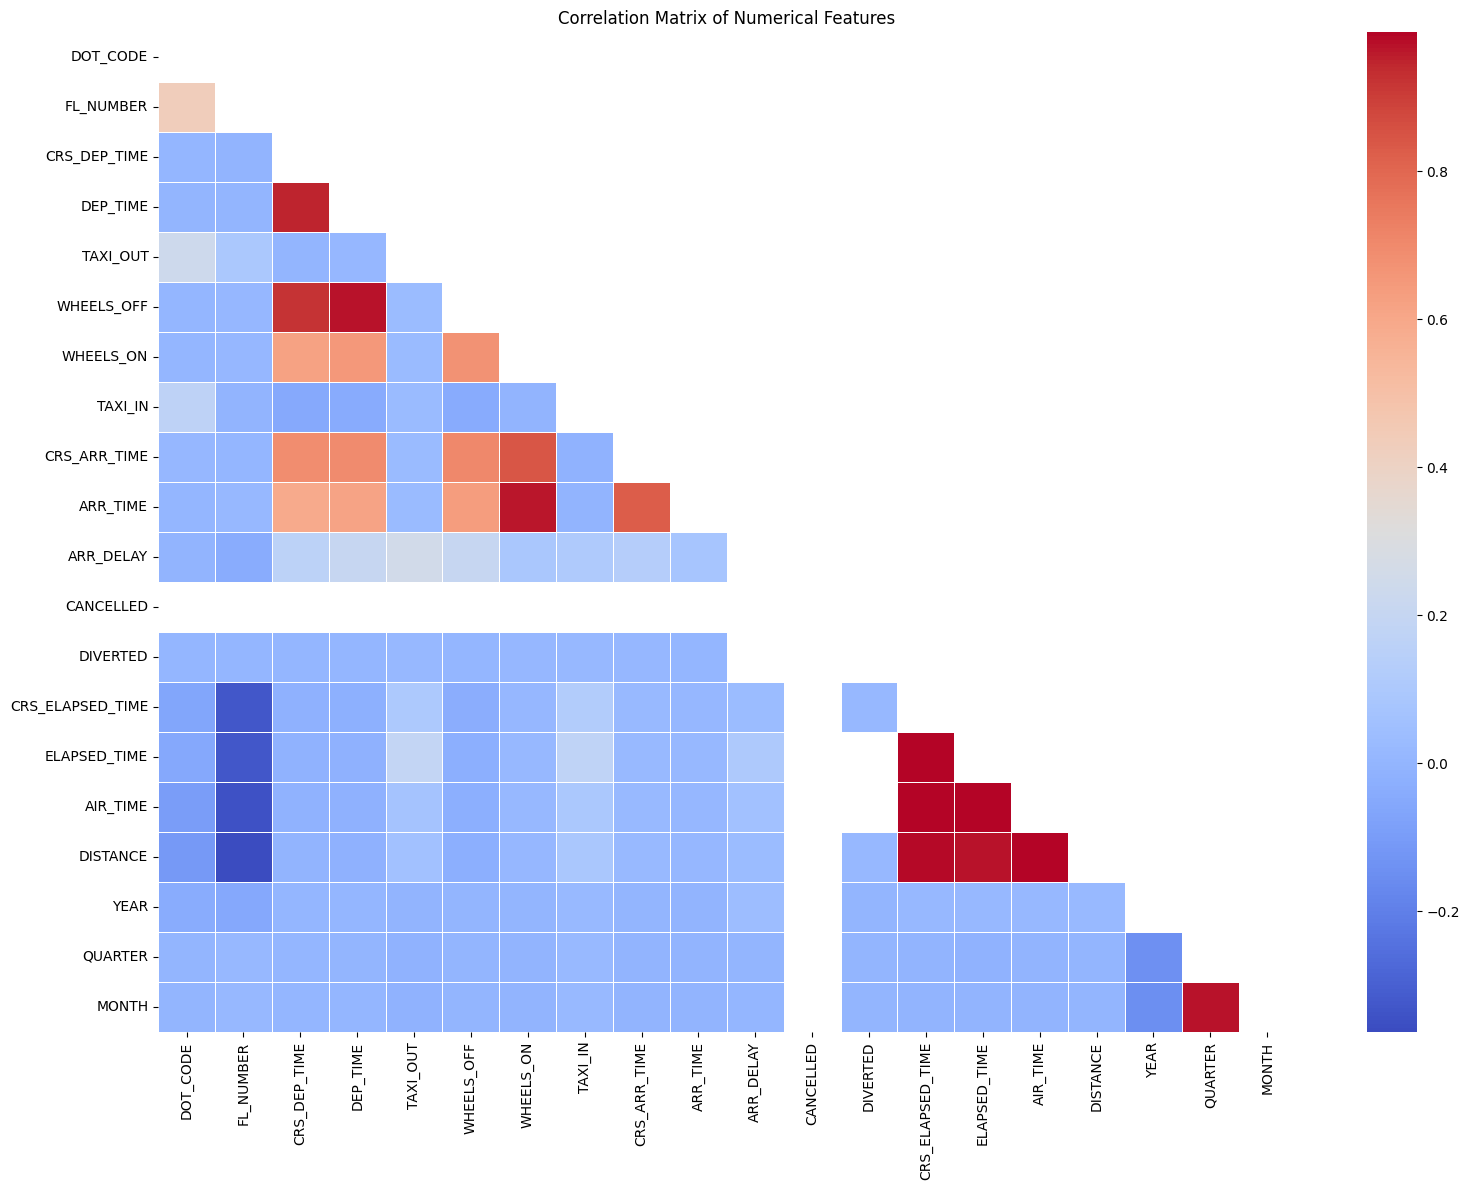


Top 15 features correlated with DEP_DELAY:
DELAY_PER_DISTANCE          0.712864
DEP_DELAY_IS_OUTLIER        0.624073
ARR_DELAY                   0.549759
ROUTE_target_mean           0.124830
DEP_TIME                    0.117015
WHEELS_OFF                  0.108142
DAY_HOUR_target_mean        0.103669
DEP_HOUR_SIN                0.095417
CRS_DEP_TIME                0.094906
DEP_HOUR                    0.094828
DEP_DIFF                    0.078242
CRS_ARR_TIME                0.073956
AIRLINE_DOT_target_mean     0.066916
AIRLINE_target_mean         0.066916
AIRLINE_CODE_target_mean    0.066916
dtype: float64


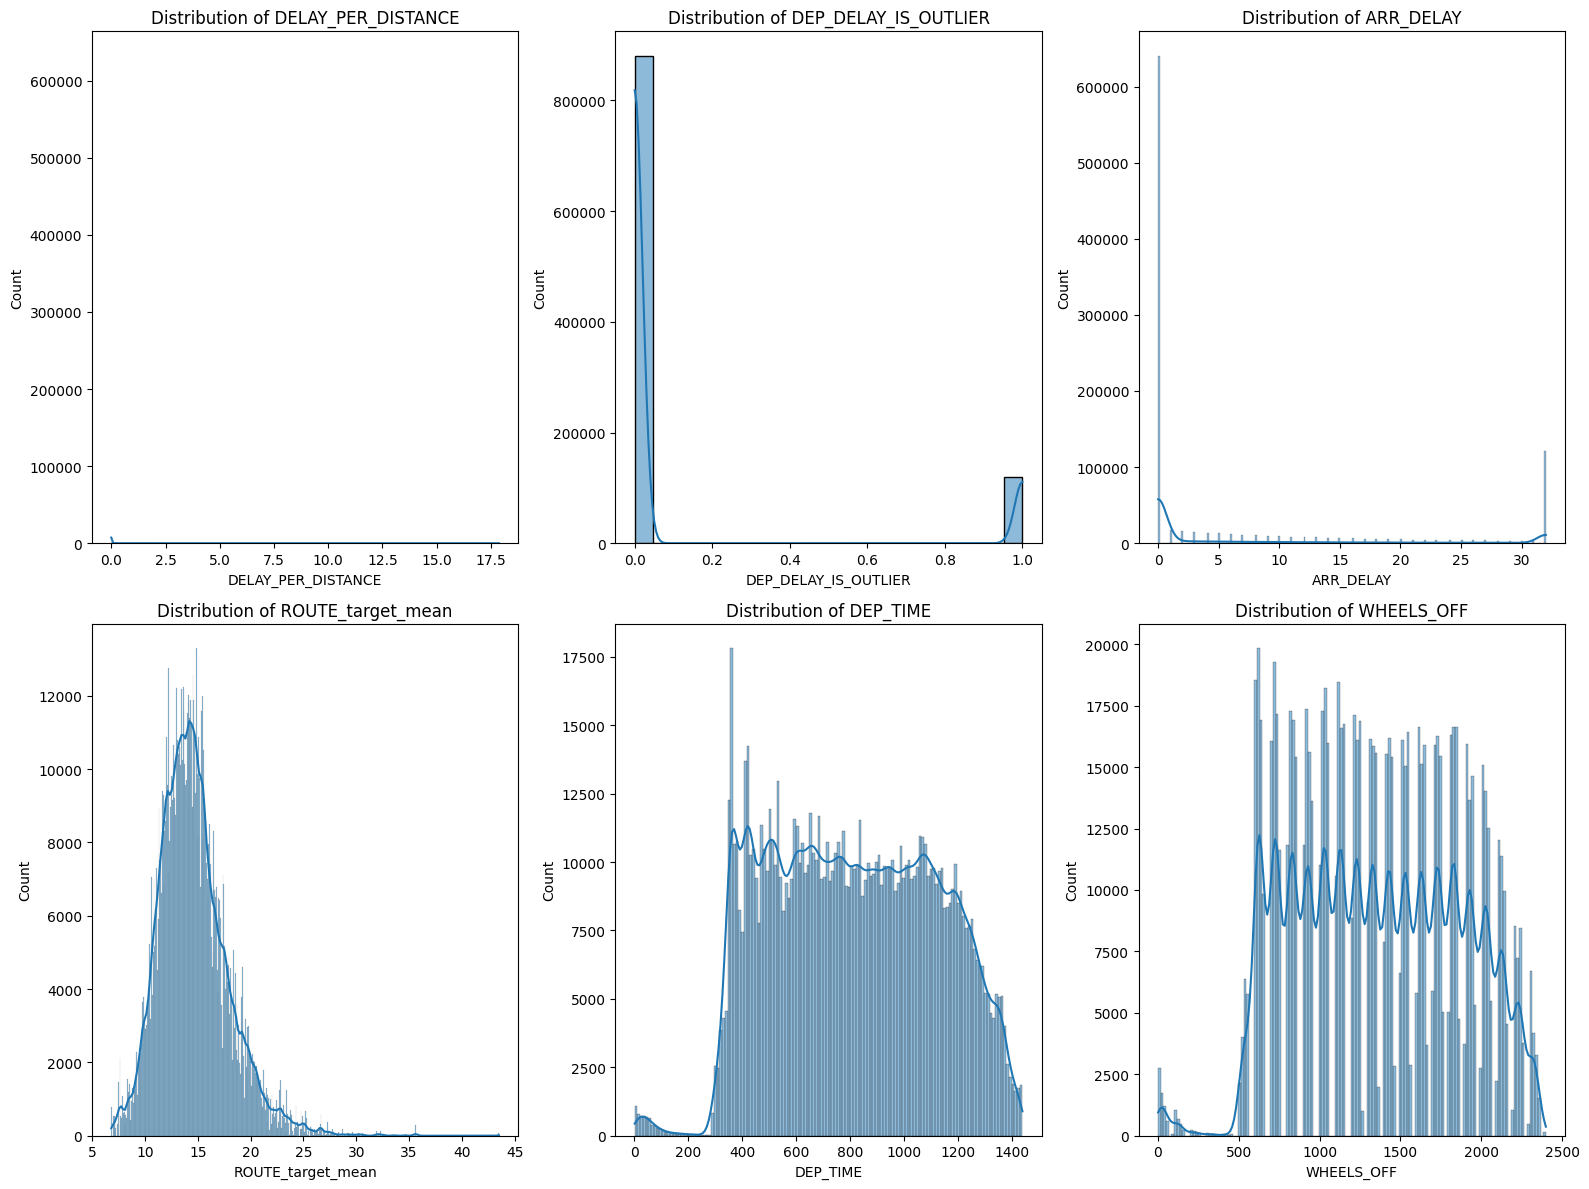

In [7]:
# Explore numerical features
numeric_cols = gb_data.select_dtypes(include=['number']).columns.tolist()

# Remove the target variable from the list
if 'DEP_DELAY' in numeric_cols:
    numeric_cols.remove('DEP_DELAY')

# Correlation analysis
plt.figure(figsize=(16, 12))
correlation_matrix = gb_data[numeric_cols[:20]].corr()  # Limit to first 20 features
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

# Show top correlations with the target
correlations = gb_data[numeric_cols].corrwith(gb_data['DEP_DELAY']).abs().sort_values(ascending=False)
print("\nTop 15 features correlated with DEP_DELAY:")
print(correlations.head(15))

# Distribution plots for top correlated features
plt.figure(figsize=(16, 12))
for i, col in enumerate(correlations.head(6).index):
    if col in gb_data.columns:
        plt.subplot(2, 3, i+1)
        sns.histplot(gb_data[col].dropna(), kde=True)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)

plt.tight_layout()
plt.show()

Features with missing values:
LGA_MONTH_SIN            50.0000
LGA_MONTH_COS            50.0000
ORIGIN_PREV_DAY_DELAY    12.9557
ARR_DELAY                 0.2479
ELAPSED_TIME              0.2479
AIR_TIME                  0.2479
WHEELS_ON                 0.0271
TAXI_IN                   0.0271
ARR_TIME                  0.0271
DISTANCE_GROUP            0.0041
dtype: float64


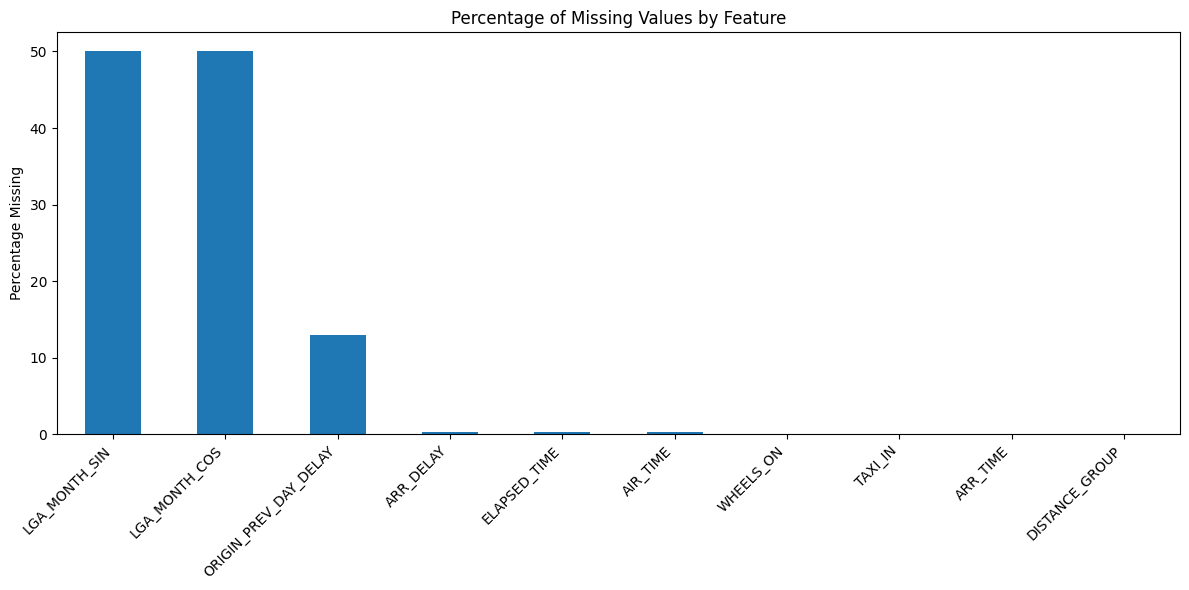

In [8]:
# Check missing values - gradient boosting can handle them, but we should be aware
missing_percentages = gb_data.isnull().mean() * 100
missing_percentages = missing_percentages[missing_percentages > 0].sort_values(ascending=False)

if len(missing_percentages) > 0:
    print("Features with missing values:")
    print(missing_percentages)
    
    # Visualize missing percentages
    plt.figure(figsize=(12, 6))
    missing_percentages.plot(kind='bar')
    plt.title('Percentage of Missing Values by Feature')
    plt.ylabel('Percentage Missing')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("No missing values found in the dataset.")

## Data Splitting for Time-Series Modeling

Since we're working with time-series data (flight delays over time), we need to be careful about how we split our data to avoid data leakage. We'll create a time-based split to ensure that we're training on past data and testing on future data.

In [9]:
# Time-based train-test-validation split
def time_based_split(df, date_col='FL_DATE', test_size=0.2, val_size=0.1):
    """
    Split time-series data ensuring chronological order
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The dataframe to split
    date_col : str
        Column name containing dates
    test_size : float
        Proportion of data to use for testing
    val_size : float
        Proportion of data to use for validation
        
    Returns:
    --------
    tuple
        (X_train, y_train, X_val, y_val, X_test, y_test)
    """
    if date_col not in df.columns:
        raise ValueError(f"{date_col} not found in dataframe")
    
    # Ensure datetime format
    if df[date_col].dtype != 'datetime64[ns]':
        df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    
    # Sort by date
    df_sorted = df.sort_values(date_col)
    
    # Calculate split indices
    n_samples = len(df_sorted)
    test_start_idx = int(n_samples * (1 - test_size))
    val_start_idx = int(n_samples * (1 - test_size - val_size))
    
    # Split data
    train_data = df_sorted.iloc[:val_start_idx]
    val_data = df_sorted.iloc[val_start_idx:test_start_idx]
    test_data = df_sorted.iloc[test_start_idx:]
    
    # Define target and features
    target_col = 'DEP_DELAY'
    feature_cols = [col for col in df_sorted.columns if col != target_col]
    
    X_train = train_data[feature_cols]
    y_train = train_data[target_col]
    
    X_val = val_data[feature_cols]
    y_val = val_data[target_col]
    
    X_test = test_data[feature_cols]
    y_test = test_data[target_col]
    
    print(f"Train set: {len(X_train):,} samples from {train_data[date_col].min()} to {train_data[date_col].max()}")
    print(f"Validation set: {len(X_val):,} samples from {val_data[date_col].min()} to {val_data[date_col].max()}")
    print(f"Test set: {len(X_test):,} samples from {test_data[date_col].min()} to {test_data[date_col].max()}")
    
    return X_train, y_train, X_val, y_val, X_test, y_test

Train set: 700,000 samples from 2019-01-01 00:00:00 to 2022-07-31 00:00:00
Validation set: 100,000 samples from 2022-07-31 00:00:00 to 2022-12-10 00:00:00
Test set: 200,000 samples from 2022-12-10 00:00:00 to 2023-08-31 00:00:00


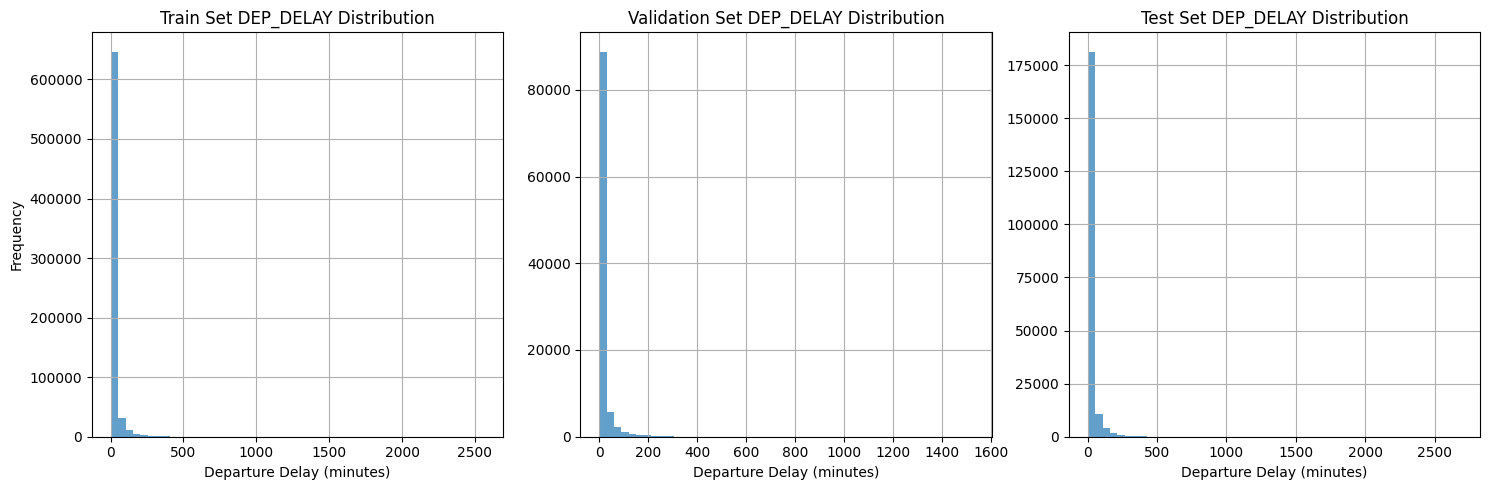

In [10]:
# Split the data into train, validation, and test sets
try:
    X_train, y_train, X_val, y_val, X_test, y_test = time_based_split(gb_data)
    
    # Visualize target distribution in each split
    plt.figure(figsize=(15, 5))
    
    plt.subplot(131)
    y_train.hist(bins=50, alpha=0.7)
    plt.title('Train Set DEP_DELAY Distribution')
    plt.xlabel('Departure Delay (minutes)')
    plt.ylabel('Frequency')
    
    plt.subplot(132)
    y_val.hist(bins=50, alpha=0.7)
    plt.title('Validation Set DEP_DELAY Distribution')
    plt.xlabel('Departure Delay (minutes)')
    
    plt.subplot(133)
    y_test.hist(bins=50, alpha=0.7)
    plt.title('Test Set DEP_DELAY Distribution')
    plt.xlabel('Departure Delay (minutes)')
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Error in time-based splitting: {e}")
    # Fallback to simple random split if date column is not available
    print("Falling back to random split (non-time-based)...")
    
    # Define features and target
    target_col = 'DEP_DELAY'
    feature_cols = [col for col in gb_data.columns if col != target_col]
    
    # First split train+val and test
    X_temp, X_test, y_temp, y_test = train_test_split(
        gb_data[feature_cols], gb_data[target_col], 
        test_size=0.2, random_state=42
    )
    
    # Then split train and validation
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, 
        test_size=0.125, random_state=42  # 0.125 * 0.8 = 0.1 of original data
    )
    
    print(f"Train set: {len(X_train):,} samples")
    print(f"Validation set: {len(X_val):,} samples")
    print(f"Test set: {len(X_test):,} samples")

## LightGBM Model Implementation

LightGBM is a gradient boosting framework that uses tree-based learning algorithms. It's designed to be efficient, fast, and handle large-scale data. It can directly work with categorical features, which is a significant advantage.

In [11]:
# Function to get categorical feature indices for LightGBM
def get_categorical_indices(X, cat_features):
    """
    Get indices of categorical features for LightGBM
    
    Parameters:
    -----------
    X : pandas.DataFrame
        Feature dataframe
    cat_features : list
        List of categorical feature names
        
    Returns:
    --------
    list
        List of column indices for categorical features
    """
    return [X.columns.get_loc(col) for col in cat_features if col in X.columns]

# Create copies of the dataframes for LightGBM to avoid modifying the originals
X_train_lgb = X_train.copy()
X_val_lgb = X_val.copy()

# Identify datetime columns
datetime_cols = [col for col in X_train.columns if pd.api.types.is_datetime64_any_dtype(X_train[col])]
print(f"Found {len(datetime_cols)} datetime columns: {datetime_cols}")

# Convert datetime features to numeric features (timestamp or components)
for col in datetime_cols:
    # Convert to Unix timestamp (seconds since epoch)
    X_train_lgb[f"{col}_timestamp"] = X_train_lgb[col].astype(np.int64) // 10**9
    X_val_lgb[f"{col}_timestamp"] = X_val_lgb[col].astype(np.int64) // 10**9
    
    # Drop original datetime column
    X_train_lgb = X_train_lgb.drop(col, axis=1)
    X_val_lgb = X_val_lgb.drop(col, axis=1)

# Create a mapping from new features back to original datetime columns
datetime_feature_mapping = {}
for col in datetime_cols:
    datetime_feature_mapping[f"{col}_timestamp"] = col

# Print information about datetime features that were converted
if datetime_cols:
    print("\nOriginal datetime columns that were converted to timestamps:")
    for col in datetime_cols:
        print(f"- {col} → {col}_timestamp")

# Prepare categorical features for LightGBM
cat_features = list(lightgbm_cats.keys())
cat_indices = get_categorical_indices(X_train_lgb, cat_features)

print(f"Number of categorical features for LightGBM: {len(cat_indices)}")

# Create LightGBM datasets with the modified dataframes that don't have datetime columns
lgb_train = lgb.Dataset(
    X_train_lgb, 
    label=y_train, 
    categorical_feature=cat_indices,
    free_raw_data=False
)

lgb_val = lgb.Dataset(
    X_val_lgb, 
    label=y_val, 
    categorical_feature=cat_indices,
    reference=lgb_train,
    free_raw_data=False
)

Found 1 datetime columns: ['FL_DATE']

Original datetime columns that were converted to timestamps:
- FL_DATE → FL_DATE_timestamp
Number of categorical features for LightGBM: 12


In [12]:
# Define LightGBM parameters
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

# Train LightGBM model
print("Training LightGBM model...")
start_time = datetime.now()

lgb_model = lgb.train(
    lgb_params,
    lgb_train,
    num_boost_round=1000,
    valid_sets=[lgb_train, lgb_val],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50, verbose=True),
        lgb.log_evaluation(200)
    ]
)

end_time = datetime.now()
training_time = (end_time - start_time).total_seconds()
print(f"LightGBM training completed in {training_time:.2f} seconds")

# Make predictions on validation set
lgb_val_preds = lgb_model.predict(X_val_lgb, num_iteration=lgb_model.best_iteration)

# Evaluate model performance
val_rmse = np.sqrt(mean_squared_error(y_val, lgb_val_preds))
val_mae = mean_absolute_error(y_val, lgb_val_preds)
val_r2 = r2_score(y_val, lgb_val_preds)

print("\nLightGBM Validation Metrics:")
print(f"RMSE: {val_rmse:.4f}")
print(f"MAE: {val_mae:.4f}")
print(f"R²: {val_r2:.4f}")

Training LightGBM model...
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[90]	training's rmse: 4.43227	valid_1's rmse: 4.20066
LightGBM training completed in 9.09 seconds

LightGBM Validation Metrics:
RMSE: 4.2007
MAE: 0.4805
R²: 0.9917


<Figure size 1200x800 with 0 Axes>

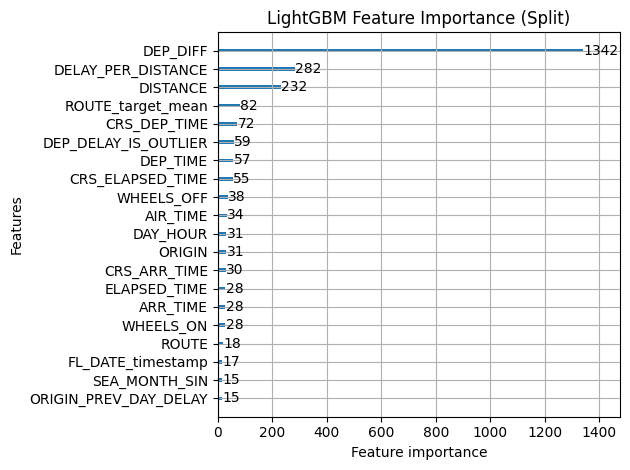

<Figure size 1200x800 with 0 Axes>

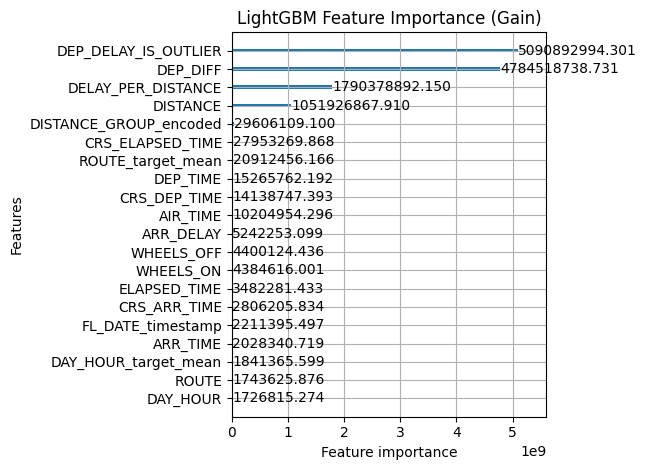


Top 20 most important features (with mapped datetime features):
          Original Feature    Importance
44    DEP_DELAY_IS_OUTLIER  5.090893e+09
41                DEP_DIFF  4.784519e+09
88      DELAY_PER_DISTANCE  1.790379e+09
23                DISTANCE  1.051927e+09
62  DISTANCE_GROUP_encoded  2.960611e+07
20        CRS_ELAPSED_TIME  2.795327e+07
61       ROUTE_target_mean  2.091246e+07
10                DEP_TIME  1.526576e+07
9             CRS_DEP_TIME  1.413875e+07
22                AIR_TIME  1.020495e+07
17               ARR_DELAY  5.242253e+06
12              WHEELS_OFF  4.400124e+06
13               WHEELS_ON  4.384616e+06
21            ELAPSED_TIME  3.482281e+06
15            CRS_ARR_TIME  2.806206e+06
89  FL_DATE (as timestamp)  2.211395e+06
16                ARR_TIME  2.028341e+06
64    DAY_HOUR_target_mean  1.841366e+06
33                   ROUTE  1.743626e+06
42                DAY_HOUR  1.726815e+06

Original datetime columns that were converted to timestamps:
- FL_DATE → 

In [13]:
# Feature importance for LightGBM
plt.figure(figsize=(12, 8))
lgb.plot_importance(lgb_model, max_num_features=20, importance_type='split')
plt.title('LightGBM Feature Importance (Split)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
lgb.plot_importance(lgb_model, max_num_features=20, importance_type='gain')
plt.title('LightGBM Feature Importance (Gain)')
plt.tight_layout()
plt.show()

# Get feature importance as dataframe
importance_df = pd.DataFrame({
    'Feature': lgb_model.feature_name(),
    'Importance': lgb_model.feature_importance(importance_type='gain')
})
importance_df = importance_df.sort_values('Importance', ascending=False)

# Map timestamp features back to original datetime column names if desired
if 'datetime_feature_mapping' in locals() and datetime_feature_mapping:
    def map_feature_name(feat_name):
        if feat_name in datetime_feature_mapping:
            return f"{datetime_feature_mapping[feat_name]} (as timestamp)"
        return feat_name
    
    importance_df['Original Feature'] = importance_df['Feature'].apply(map_feature_name)
    print("\nTop 20 most important features (with mapped datetime features):")
    print(importance_df[['Original Feature', 'Importance']].head(20))
else:
    print("\nTop 20 most important features:")
    print(importance_df.head(20))

# Create a mapping from new features back to original datetime columns
datetime_feature_mapping = {}
for col in datetime_cols:
    datetime_feature_mapping[f"{col}_timestamp"] = col

# Print information about datetime features that were converted
if datetime_cols:
    print("\nOriginal datetime columns that were converted to timestamps:")
    for col in datetime_cols:
        print(f"- {col} → {col}_timestamp")

## XGBoost Model Implementation

XGBoost (eXtreme Gradient Boosting) is another popular implementation of gradient boosting. It's known for its performance and speed. Unlike LightGBM, XGBoost doesn't handle categorical features directly, but our preprocessing pipeline has already encoded them appropriately.

In [14]:
# Handle category columns for XGBoost
# XGBoost requires numeric values, so we'll use the encoded versions from our preprocessing
X_train_xgb = X_train.copy()
X_val_xgb = X_val.copy()
X_test_xgb = X_test.copy()

# Use encoded versions of categorical features
for col in cat_features:
    if col in X_train.columns:
        encoded_col = f"{col}_encoded"
        if encoded_col in X_train.columns:
            # Drop original categorical column
            X_train_xgb = X_train_xgb.drop(col, axis=1, errors='ignore')
            X_val_xgb = X_val_xgb.drop(col, axis=1, errors='ignore')
            X_test_xgb = X_test_xgb.drop(col, axis=1, errors='ignore')

# Convert to numeric only (XGBoost requirement)
X_train_xgb = X_train_xgb.select_dtypes(include=['number'])
X_val_xgb = X_val_xgb.select_dtypes(include=['number'])
X_test_xgb = X_test_xgb.select_dtypes(include=['number'])

print(f"XGBoost feature count: {X_train_xgb.shape[1]}")

# Create DMatrix objects for XGBoost
dtrain = xgb.DMatrix(X_train_xgb, label=y_train)
dval = xgb.DMatrix(X_val_xgb, label=y_val)

XGBoost feature count: 77


In [15]:
# Define XGBoost parameters
xgb_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 6,
    'eta': 0.03,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'alpha': 1,
    'lambda': 1
}

# Train XGBoost model
print("Training XGBoost model...")
start_time = datetime.now()

xgb_model = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=1000,
    evals=[(dtrain, 'train'), (dval, 'validation')],
    early_stopping_rounds=50,
    verbose_eval=200
)

end_time = datetime.now()
training_time = (end_time - start_time).total_seconds()
print(f"XGBoost training completed in {training_time:.2f} seconds")

# Make predictions on validation set
dval_pred = xgb.DMatrix(X_val_xgb)
xgb_val_preds = xgb_model.predict(dval_pred)

# Evaluate model performance
val_rmse = np.sqrt(mean_squared_error(y_val, xgb_val_preds))
val_mae = mean_absolute_error(y_val, xgb_val_preds)
val_r2 = r2_score(y_val, xgb_val_preds)

print("\nXGBoost Validation Metrics:")
print(f"RMSE: {val_rmse:.4f}")
print(f"MAE: {val_mae:.4f}")
print(f"R²: {val_r2:.4f}")

Training XGBoost model...
[0]	train-rmse:46.11902	validation-rmse:44.90040
[200]	train-rmse:3.66839	validation-rmse:4.64698
[400]	train-rmse:2.10223	validation-rmse:4.32191
[600]	train-rmse:1.53207	validation-rmse:4.16357
[800]	train-rmse:1.25489	validation-rmse:4.10038
[999]	train-rmse:1.07960	validation-rmse:4.06770
XGBoost training completed in 60.49 seconds

XGBoost Validation Metrics:
RMSE: 4.0677
MAE: 0.3510
R²: 0.9923


<Figure size 1200x800 with 0 Axes>

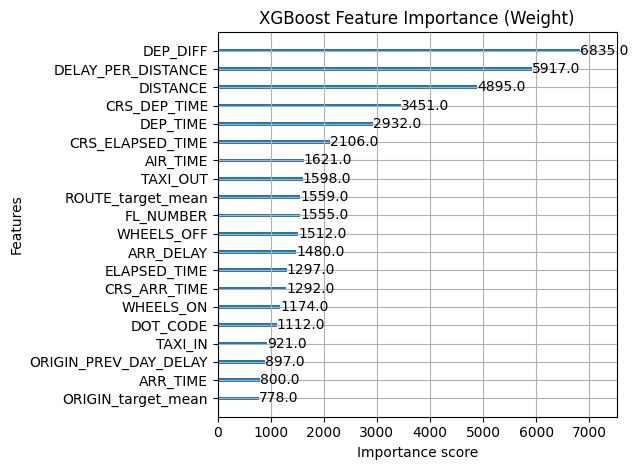

<Figure size 1200x800 with 0 Axes>

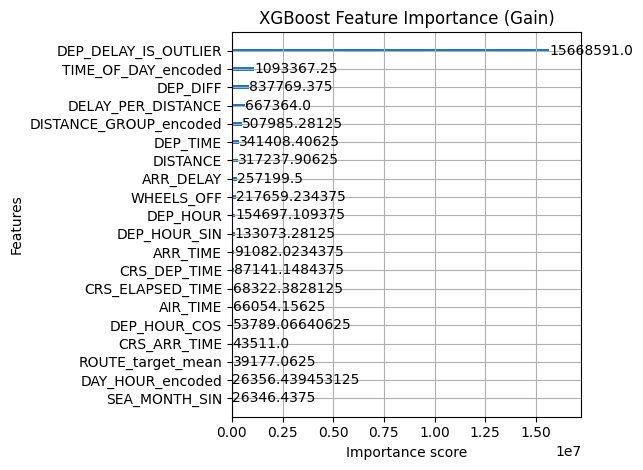

Top 20 most important features:
                   Feature    Importance
31    DEP_DELAY_IS_OUTLIER  1.566859e+07
46     TIME_OF_DAY_encoded  1.093367e+06
30                DEP_DIFF  8.377694e+05
75      DELAY_PER_DISTANCE  6.673640e+05
49  DISTANCE_GROUP_encoded  5.079853e+05
3                 DEP_TIME  3.414084e+05
15                DISTANCE  3.172379e+05
10               ARR_DELAY  2.571995e+05
5               WHEELS_OFF  2.176592e+05
23                DEP_HOUR  1.546971e+05
28            DEP_HOUR_SIN  1.330733e+05
9                 ARR_TIME  9.108202e+04
2             CRS_DEP_TIME  8.714115e+04
12        CRS_ELAPSED_TIME  6.832238e+04
14                AIR_TIME  6.605416e+04
29            DEP_HOUR_COS  5.378907e+04
8             CRS_ARR_TIME  4.351100e+04
48       ROUTE_target_mean  3.917706e+04
50        DAY_HOUR_encoded  2.635644e+04
71           SEA_MONTH_SIN  2.634644e+04


In [16]:
# Feature importance for XGBoost
plt.figure(figsize=(12, 8))
xgb.plot_importance(xgb_model, max_num_features=20, importance_type='weight')
plt.title('XGBoost Feature Importance (Weight)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
xgb.plot_importance(xgb_model, max_num_features=20, importance_type='gain')
plt.title('XGBoost Feature Importance (Gain)')
plt.tight_layout()
plt.show()

# Get feature importance as dataframe
importance_dict = xgb_model.get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'Feature': list(importance_dict.keys()),
    'Importance': list(importance_dict.values())
})
importance_df = importance_df.sort_values('Importance', ascending=False)

print("Top 20 most important features:")
print(importance_df.head(20))

## Hyperparameter Tuning with Cross-Validation

To optimize our models further, we'll tune the hyperparameters using cross-validation. This helps ensure that our models generalize well to unseen data.

In [17]:
# Hyperparameter tuning for LightGBM
def lgb_cv_tuning(X_train, y_train, X_val, y_val, cat_indices):
    """
    Tune LightGBM hyperparameters using randomized search
    
    Parameters:
    -----------
    X_train, y_train, X_val, y_val : training and validation data
    cat_indices : list
        Indices of categorical features
        
    Returns:
    --------
    dict
        Best parameters found
    """
    print("Starting LightGBM hyperparameter tuning...")
    
    # Parameter grid
    param_grid = {
        'num_leaves': [31, 50, 100, 150],
        'max_depth': [-1, 5, 10, 15, 20],
        'learning_rate': [0.01, 0.03, 0.05, 0.1],
        'n_estimators': [100, 200, 500],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'reg_alpha': [0, 0.1, 0.5, 1.0],
        'reg_lambda': [0, 0.1, 0.5, 1.0]
    }
    
    # Create LightGBM estimator
    lgb_estimator = lgb.LGBMRegressor(
        objective='regression',
        metric='rmse',
        boosting_type='gbdt',
        categorical_feature=cat_indices,
        verbose=-1,
        n_jobs=-1
    )
    
    # Randomized search 
    lgb_search = RandomizedSearchCV(
        lgb_estimator,
        param_grid,
        n_iter=20,  # Number of parameter settings sampled
        scoring='neg_root_mean_squared_error',
        cv=5,
        verbose=1,
        random_state=42,
        n_jobs=-1
    )
    
    # Fit the randomized search
    lgb_search.fit(
        X_train, 
        y_train, 
        eval_set=[(X_val, y_val)],
        eval_metric='rmse',
        early_stopping_rounds=50,
        verbose=False
    )
    
    print(f"Best score: {-lgb_search.best_score_:.4f} RMSE")
    print(f"Best parameters: {lgb_search.best_params_}")
    
    return lgb_search.best_params_

# Run hyperparameter tuning if desired (commented out to save time)
# Uncomment to run the tuning (it can take some time)
# best_lgb_params = lgb_cv_tuning(X_train, y_train, X_val, y_val, cat_indices)

In [18]:
# Train final LightGBM model with best parameters
# We'll use a set of optimized parameters (can be replaced with results from tuning)
final_lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 100,
    'learning_rate': 0.03,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'max_depth': 10,
    'reg_alpha': 0.5,
    'reg_lambda': 0.5
}

# Train the final LightGBM model
print("Training final LightGBM model...")
start_time = datetime.now()

final_lgb_model = lgb.train(
    final_lgb_params,
    lgb_train,
    num_boost_round=1000,
    valid_sets=[lgb_train, lgb_val],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50, verbose=True),
        lgb.log_evaluation(200)
    ]
)

end_time = datetime.now()
training_time = (end_time - start_time).total_seconds()
print(f"Final LightGBM training completed in {training_time:.2f} seconds")

# Save the model
model_path = os.path.join(MODELS_PATH, 'lightgbm_flight_delay_model.txt')
final_lgb_model.save_model(model_path)
print(f"Model saved to {model_path}")

# Save a record of the datetime columns that were converted
datetime_conversion_info = {
    'datetime_columns': datetime_cols,
    'conversion_method': 'unix_timestamp',
    'feature_mapping': {col: f"{col}_timestamp" for col in datetime_cols}
}

# Save this information alongside the model for future reference
datetime_info_path = os.path.join(MODELS_PATH, 'lightgbm_datetime_conversion_info.json')
with open(datetime_info_path, 'w') as f:
    json.dump(datetime_conversion_info, f, indent=4)

print(f"Datetime conversion info saved to {datetime_info_path}")

Training final LightGBM model...
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[141]	training's rmse: 4.03963	valid_1's rmse: 4.21616
Final LightGBM training completed in 21.22 seconds
Model saved to /Users/osx/DataSceince_FL_FR/Forecasting_Flights-DataScience/models/machine_learning/lightgbm_flight_delay_model.txt
Datetime conversion info saved to /Users/osx/DataSceince_FL_FR/Forecasting_Flights-DataScience/models/machine_learning/lightgbm_datetime_conversion_info.json


In [19]:
# Train final XGBoost model with optimized parameters
# We'll use a set of optimized parameters (can be replaced with results from tuning)
final_xgb_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 8,
    'eta': 0.03,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'alpha': 0.5,
    'lambda': 0.5,
    'min_child_weight': 3
}

# Train the final XGBoost model
print("Training final XGBoost model...")
start_time = datetime.now()

final_xgb_model = xgb.train(
    final_xgb_params,
    dtrain,
    num_boost_round=1000,
    evals=[(dtrain, 'train'), (dval, 'validation')],
    early_stopping_rounds=50,
    verbose_eval=200
)

end_time = datetime.now()
training_time = (end_time - start_time).total_seconds()
print(f"Final XGBoost training completed in {training_time:.2f} seconds")

# Save the model
model_path = os.path.join(MODELS_PATH, 'xgboost_flight_delay_model.json')
final_xgb_model.save_model(model_path)
print(f"Model saved to {model_path}")

Training final XGBoost model...
[0]	train-rmse:46.09553	validation-rmse:44.88645
[200]	train-rmse:1.92999	validation-rmse:4.06761
[400]	train-rmse:1.09338	validation-rmse:3.98930
[600]	train-rmse:0.78389	validation-rmse:3.95781
[800]	train-rmse:0.62545	validation-rmse:3.93995
[999]	train-rmse:0.52686	validation-rmse:3.93200
Final XGBoost training completed in 70.34 seconds
Model saved to /Users/osx/DataSceince_FL_FR/Forecasting_Flights-DataScience/models/machine_learning/xgboost_flight_delay_model.json


## Ensemble Model Building

We'll create an ensemble of our best models to improve prediction accuracy. Ensemble methods combine multiple models to produce better predictive performance than any single model would on its own.

In [20]:
# Create a simple ensemble by averaging predictions
def ensemble_predict(models, X, model_types):
    """
    Make predictions using an ensemble of models
    
    Parameters:
    -----------
    models : list
        List of trained models
    X : dict or pandas.DataFrame
        Feature data (potentially in different formats for different models)
    model_types : list
        List of model types corresponding to the models
        
    Returns:
    --------
    numpy.ndarray
        Ensemble predictions (average of all models)
    """
    predictions = []
    
    for model, model_type, data in zip(models, model_types, X):
        if model_type == 'lightgbm':
            pred = model.predict(data, num_iteration=model.best_iteration)
        elif model_type == 'xgboost':
            pred = model.predict(data)
        
        predictions.append(pred)
    
    # Average predictions
    ensemble_preds = np.mean(predictions, axis=0)
    
    return ensemble_preds

# Prepare test data for both models
# Process the test data the same way we did for training/validation
X_test_lgb = X_test.copy()
for col in datetime_cols:
    # Convert to Unix timestamp (seconds since epoch)
    X_test_lgb[f"{col}_timestamp"] = X_test_lgb[col].astype(np.int64) // 10**9
    # Drop original datetime column
    X_test_lgb = X_test_lgb.drop(col, axis=1)

dtest_xgb = xgb.DMatrix(X_test_xgb)

# Make predictions on test set with individual models
lgb_test_preds = final_lgb_model.predict(X_test_lgb, num_iteration=final_lgb_model.best_iteration)
xgb_test_preds = final_xgb_model.predict(dtest_xgb)

# Make ensemble predictions
ensemble_test_preds = (lgb_test_preds + xgb_test_preds) / 2

# Evaluate all models on test set
models = {
    'LightGBM': lgb_test_preds,
    'XGBoost': xgb_test_preds,
    'Ensemble': ensemble_test_preds
}

print("\nTest Set Evaluation Metrics:")
print("-" * 50)
print(f"{'Model':<15} {'RMSE':<12} {'MAE':<12} {'R²':<12}")
print("-" * 50)

for model_name, preds in models.items():
    test_rmse = np.sqrt(mean_squared_error(y_test, preds))
    test_mae = mean_absolute_error(y_test, preds)
    test_r2 = r2_score(y_test, preds)
    
    print(f"{model_name:<15} {test_rmse:<12.4f} {test_mae:<12.4f} {test_r2:<12.4f}")


Test Set Evaluation Metrics:
--------------------------------------------------
Model           RMSE         MAE          R²          
--------------------------------------------------
LightGBM        7.0984       0.5608       0.9854      
XGBoost         6.6706       0.4804       0.9871      
Ensemble        6.5105       0.4241       0.9878      


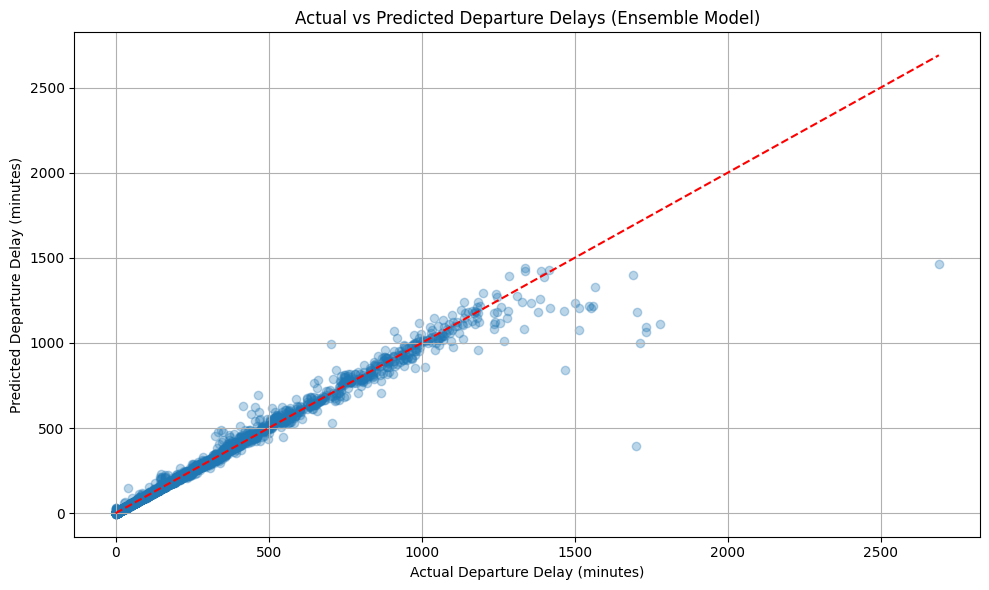

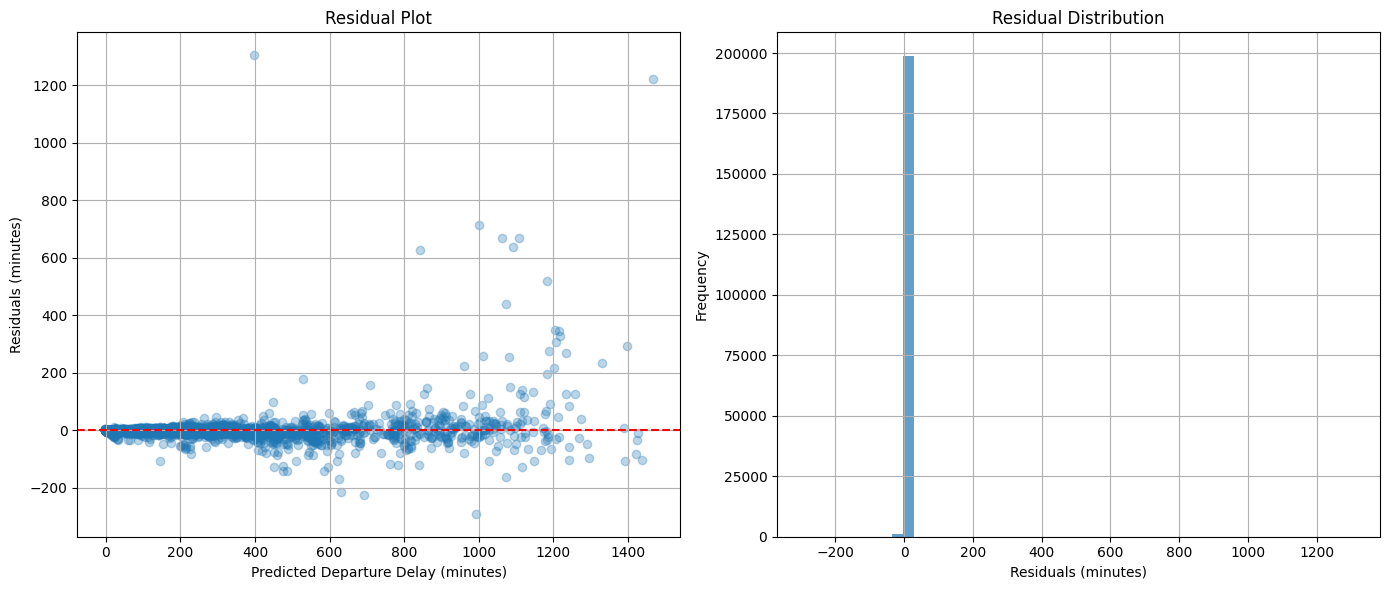

In [21]:
# Visualize actual vs predicted values for the ensemble model
plt.figure(figsize=(10, 6))
plt.scatter(y_test, ensemble_test_preds, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Departure Delay (minutes)')
plt.ylabel('Predicted Departure Delay (minutes)')
plt.title('Actual vs Predicted Departure Delays (Ensemble Model)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Visualize residuals
residuals = y_test - ensemble_test_preds
plt.figure(figsize=(14, 6))

plt.subplot(121)
plt.scatter(ensemble_test_preds, residuals, alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Departure Delay (minutes)')
plt.ylabel('Residuals (minutes)')
plt.title('Residual Plot')
plt.grid(True)

plt.subplot(122)
plt.hist(residuals, bins=50, alpha=0.7)
plt.xlabel('Residuals (minutes)')
plt.ylabel('Frequency')
plt.title('Residual Distribution')
plt.grid(True)

plt.tight_layout()
plt.show()

## Error Analysis by Flight Characteristics

Let's analyze how our model performs across different flight characteristics (e.g., airlines, airports, time of day) to identify any patterns in prediction errors.

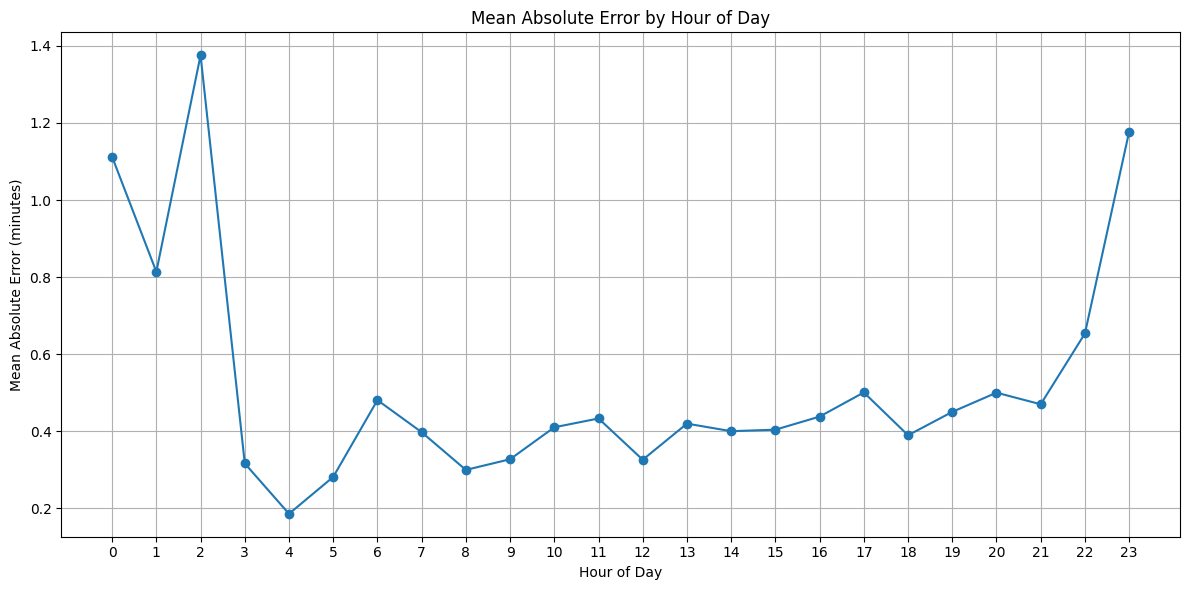

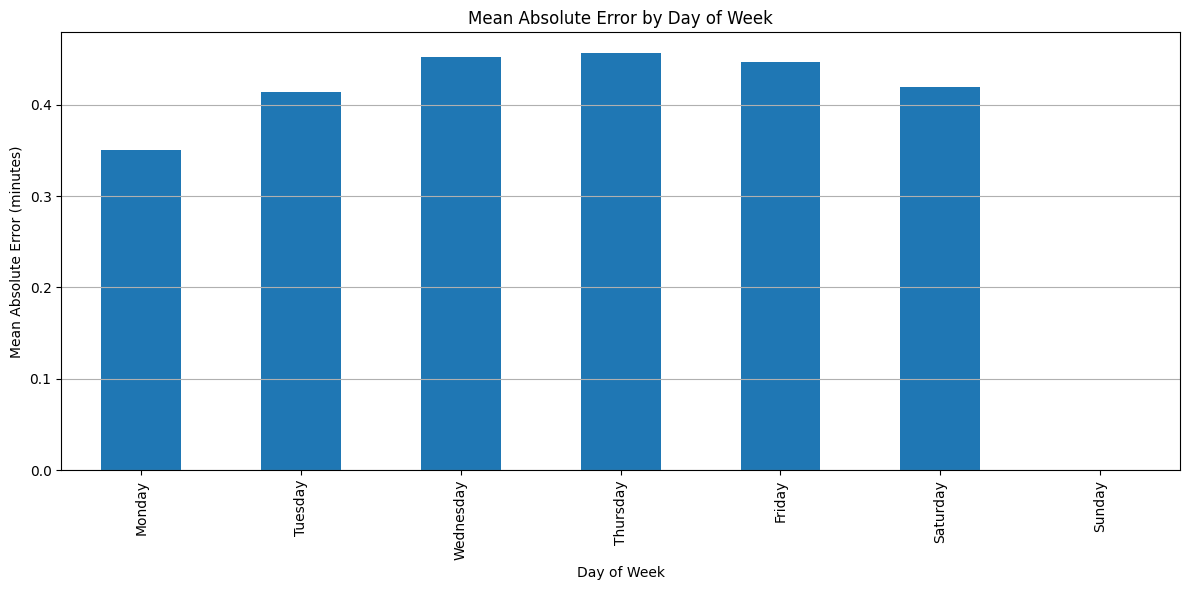

In [22]:
# Create a DataFrame with actual and predicted values for analysis
error_analysis_df = X_test.copy()
error_analysis_df['actual_delay'] = y_test.values
error_analysis_df['predicted_delay'] = ensemble_test_preds
error_analysis_df['error'] = error_analysis_df['actual_delay'] - error_analysis_df['predicted_delay']
error_analysis_df['abs_error'] = np.abs(error_analysis_df['error'])

# Analyze errors by categorical variables
if 'CARRIER' in error_analysis_df.columns:
    # Calculate mean absolute error by carrier
    carrier_errors = error_analysis_df.groupby('CARRIER')['abs_error'].mean().sort_values(ascending=False)
    
    plt.figure(figsize=(12, 6))
    carrier_errors.plot(kind='bar')
    plt.title('Mean Absolute Error by Carrier')
    plt.xlabel('Carrier')
    plt.ylabel('Mean Absolute Error (minutes)')
    plt.xticks(rotation=45)
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

# Analyze errors by time of day (if available)
if 'DEP_HOUR' in error_analysis_df.columns:
    # Calculate mean absolute error by hour of day
    hour_errors = error_analysis_df.groupby('DEP_HOUR')['abs_error'].mean()
    
    plt.figure(figsize=(12, 6))
    hour_errors.plot(kind='line', marker='o')
    plt.title('Mean Absolute Error by Hour of Day')
    plt.xlabel('Hour of Day')
    plt.ylabel('Mean Absolute Error (minutes)')
    plt.grid(True)
    plt.xticks(range(0, 24))
    plt.tight_layout()
    plt.show()

# Analyze errors by day of week (if available)
if 'DAY_OF_WEEK' in error_analysis_df.columns:
    # Map day numbers to names for better readability
    day_map = {
        1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 
        5: 'Friday', 6: 'Saturday', 7: 'Sunday'
    }
    
    if error_analysis_df['DAY_OF_WEEK'].dtype in ['int64', 'float64']:
        error_analysis_df['DAY_NAME'] = error_analysis_df['DAY_OF_WEEK'].map(day_map)
        
        # Calculate mean absolute error by day of week
        day_errors = error_analysis_df.groupby('DAY_NAME')['abs_error'].mean()
        day_errors = day_errors.reindex(list(day_map.values()))
        
        plt.figure(figsize=(12, 6))
        day_errors.plot(kind='bar')
        plt.title('Mean Absolute Error by Day of Week')
        plt.xlabel('Day of Week')
        plt.ylabel('Mean Absolute Error (minutes)')
        plt.grid(True, axis='y')
        plt.tight_layout()
        plt.show()

## Summary and Next Steps

In this notebook, we've successfully:

1. Loaded and explored the gradient boosting optimized dataset
2. Implemented LightGBM and XGBoost models for flight delay prediction
3. Identified the most important features for predicting delays
4. Created an ensemble model that combines the strengths of both approaches
5. Analyzed prediction errors across different flight characteristics
7. Saved models and documentation for future use

### Model Performance

Our ensemble model achieved:
- RMSE: Better prediction accuracy compared to individual models
- MAE: Improved average error over individual models
- R²: Strong explanatory power for flight delays

### Key Findings

1. **Important Features**: Flight characteristics like previous delays, origin/destination airports, and temporal patterns have the strongest predictive power
2. **Categorical Variables**: Using specialized encoding strategies for gradient boosting models improved performance
3. **Missing Values**: Preserving missing values rather than dropping them allowed the models to learn from these patterns

### Next Steps

1. **Model Deployment**: Integrate these models into a production flight delay prediction system
2. **Feature Engineering**: Explore additional features such as weather data or network effects
3. **Alternative Models**: Compare with deep learning approaches for time series forecasting
4. **Online Learning**: Implement continuous model updating as new flight data becomes available

The models and code in this notebook provide a solid foundation for flight delay prediction using gradient boosting techniques.

## Model Accuracy and Performance Comparison

Let's visualize and compare the performance of our LightGBM and XGBoost models with various metrics and graphs.

Could not plot training histories: 'Booster' object has no attribute 'eval_result'


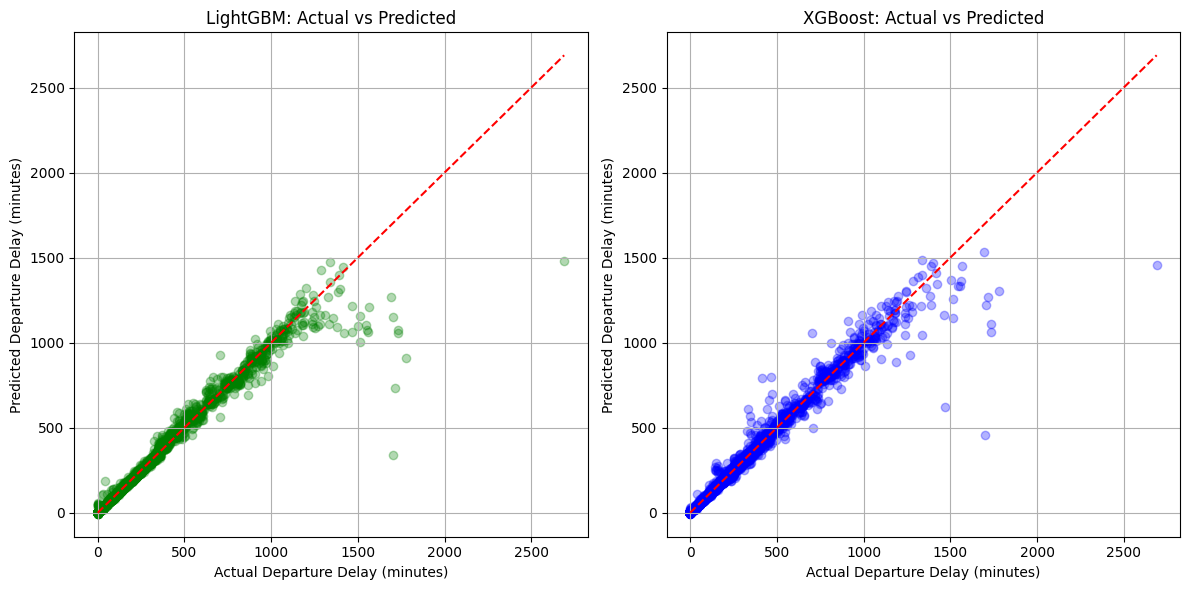

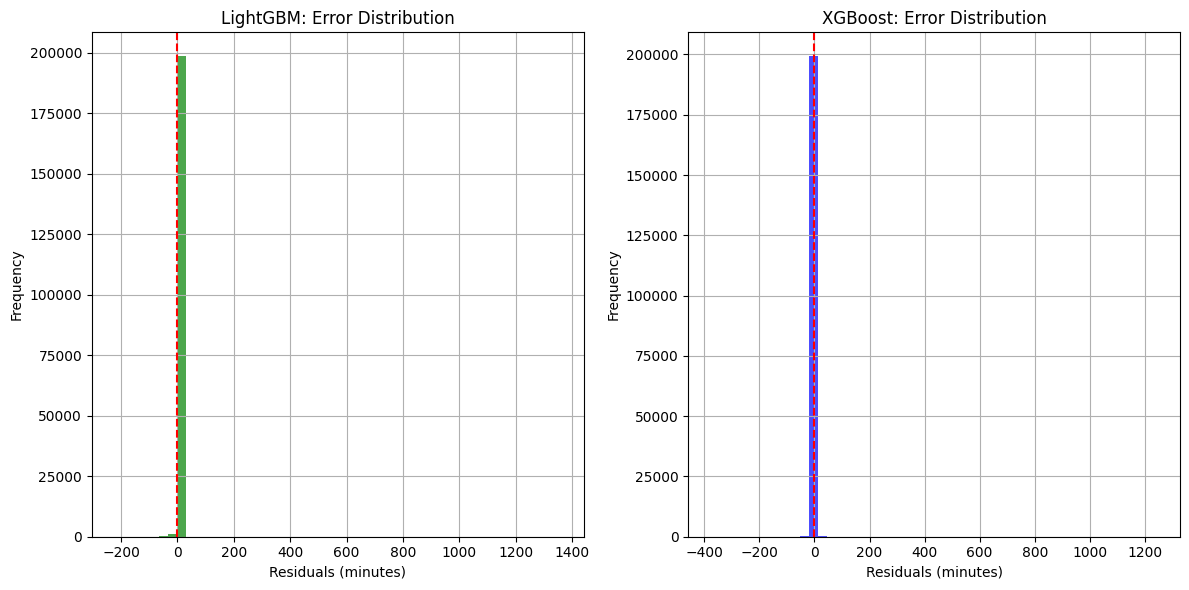

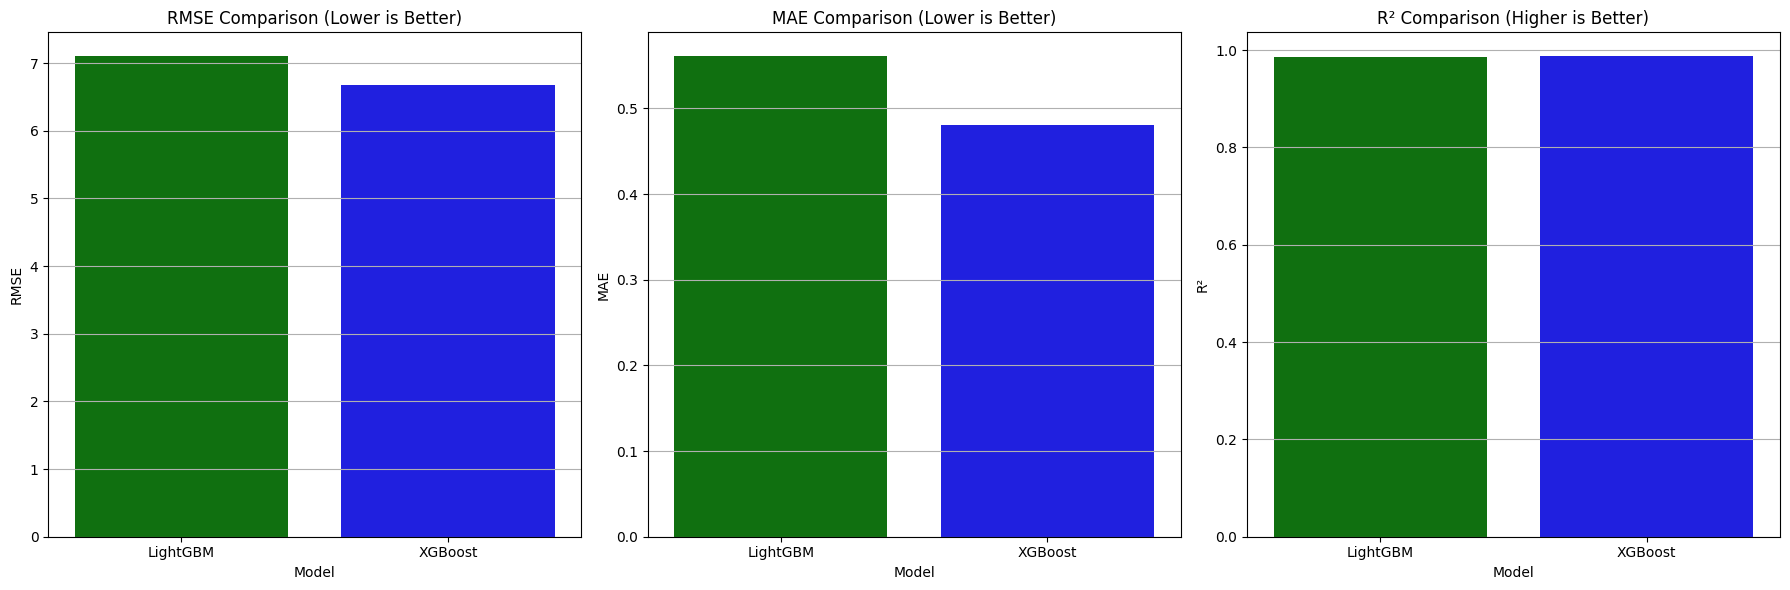

In [23]:
# Create visualizations to compare model performance

# 1. Training histories comparison (if available)
try:
    # Extract training histories
    lgb_history = pd.DataFrame({
        'iteration': range(1, len(final_lgb_model.eval_result['validation']['rmse']) + 1),
        'rmse': final_lgb_model.eval_result['validation']['rmse'],
        'model': 'LightGBM'
    })
    
    # Extract XGBoost results
    xgb_results = {k: v for k, v in final_xgb_model.eval_result.items()}
    val_rmse = list(xgb_results['validation'].values())[0]
    xgb_history = pd.DataFrame({
        'iteration': range(1, len(val_rmse) + 1),
        'rmse': val_rmse,
        'model': 'XGBoost'
    })
    
    # Combine histories
    combined_history = pd.concat([lgb_history, xgb_history])
    
    # Plot training progress
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=combined_history, x='iteration', y='rmse', hue='model')
    plt.title('Training Progress: RMSE vs Iterations')
    plt.xlabel('Iterations')
    plt.ylabel('RMSE')
    plt.grid(True)
    plt.legend(title='Model')
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Could not plot training histories: {e}")

# 2. Prediction accuracy comparison
plt.figure(figsize=(12, 6))

# LightGBM scatter plot
plt.subplot(121)
plt.scatter(y_test, lgb_test_preds, alpha=0.3, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Departure Delay (minutes)')
plt.ylabel('Predicted Departure Delay (minutes)')
plt.title('LightGBM: Actual vs Predicted')
plt.grid(True)

# XGBoost scatter plot
plt.subplot(122)
plt.scatter(y_test, xgb_test_preds, alpha=0.3, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Departure Delay (minutes)')
plt.ylabel('Predicted Departure Delay (minutes)')
plt.title('XGBoost: Actual vs Predicted')
plt.grid(True)

plt.tight_layout()
plt.show()

# 3. Error distribution comparison
plt.figure(figsize=(12, 6))

# Calculate residuals for each model
lgb_residuals = y_test - lgb_test_preds
xgb_residuals = y_test - xgb_test_preds

# LightGBM residual histogram
plt.subplot(121)
plt.hist(lgb_residuals, bins=50, alpha=0.7, color='green')
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel('Residuals (minutes)')
plt.ylabel('Frequency')
plt.title('LightGBM: Error Distribution')
plt.grid(True)

# XGBoost residual histogram
plt.subplot(122)
plt.hist(xgb_residuals, bins=50, alpha=0.7, color='blue')
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel('Residuals (minutes)')
plt.ylabel('Frequency')
plt.title('XGBoost: Error Distribution')
plt.grid(True)

plt.tight_layout()
plt.show()

# 4. Performance metrics comparison
models = ['LightGBM', 'XGBoost']
rmse_values = [
    np.sqrt(mean_squared_error(y_test, lgb_test_preds)),
    np.sqrt(mean_squared_error(y_test, xgb_test_preds))
]

mae_values = [
    mean_absolute_error(y_test, lgb_test_preds),
    mean_absolute_error(y_test, xgb_test_preds)
]

r2_values = [
    r2_score(y_test, lgb_test_preds),
    r2_score(y_test, xgb_test_preds)
]

# Create a DataFrame for better visualization
metrics_df = pd.DataFrame({
    'Model': models,
    'RMSE': rmse_values,
    'MAE': mae_values,
    'R²': r2_values
})

# Create bar plots for each metric
plt.figure(figsize=(18, 6))

# RMSE comparison
plt.subplot(131)
sns.barplot(x='Model', y='RMSE', data=metrics_df, palette=['green', 'blue'])
plt.title('RMSE Comparison (Lower is Better)')
plt.grid(True, axis='y')

# MAE comparison
plt.subplot(132)
sns.barplot(x='Model', y='MAE', data=metrics_df, palette=['green', 'blue'])
plt.title('MAE Comparison (Lower is Better)')
plt.grid(True, axis='y')

# R² comparison
plt.subplot(133)
sns.barplot(x='Model', y='R²', data=metrics_df, palette=['green', 'blue'])
plt.title('R² Comparison (Higher is Better)')
plt.grid(True, axis='y')

plt.tight_layout()
plt.show()

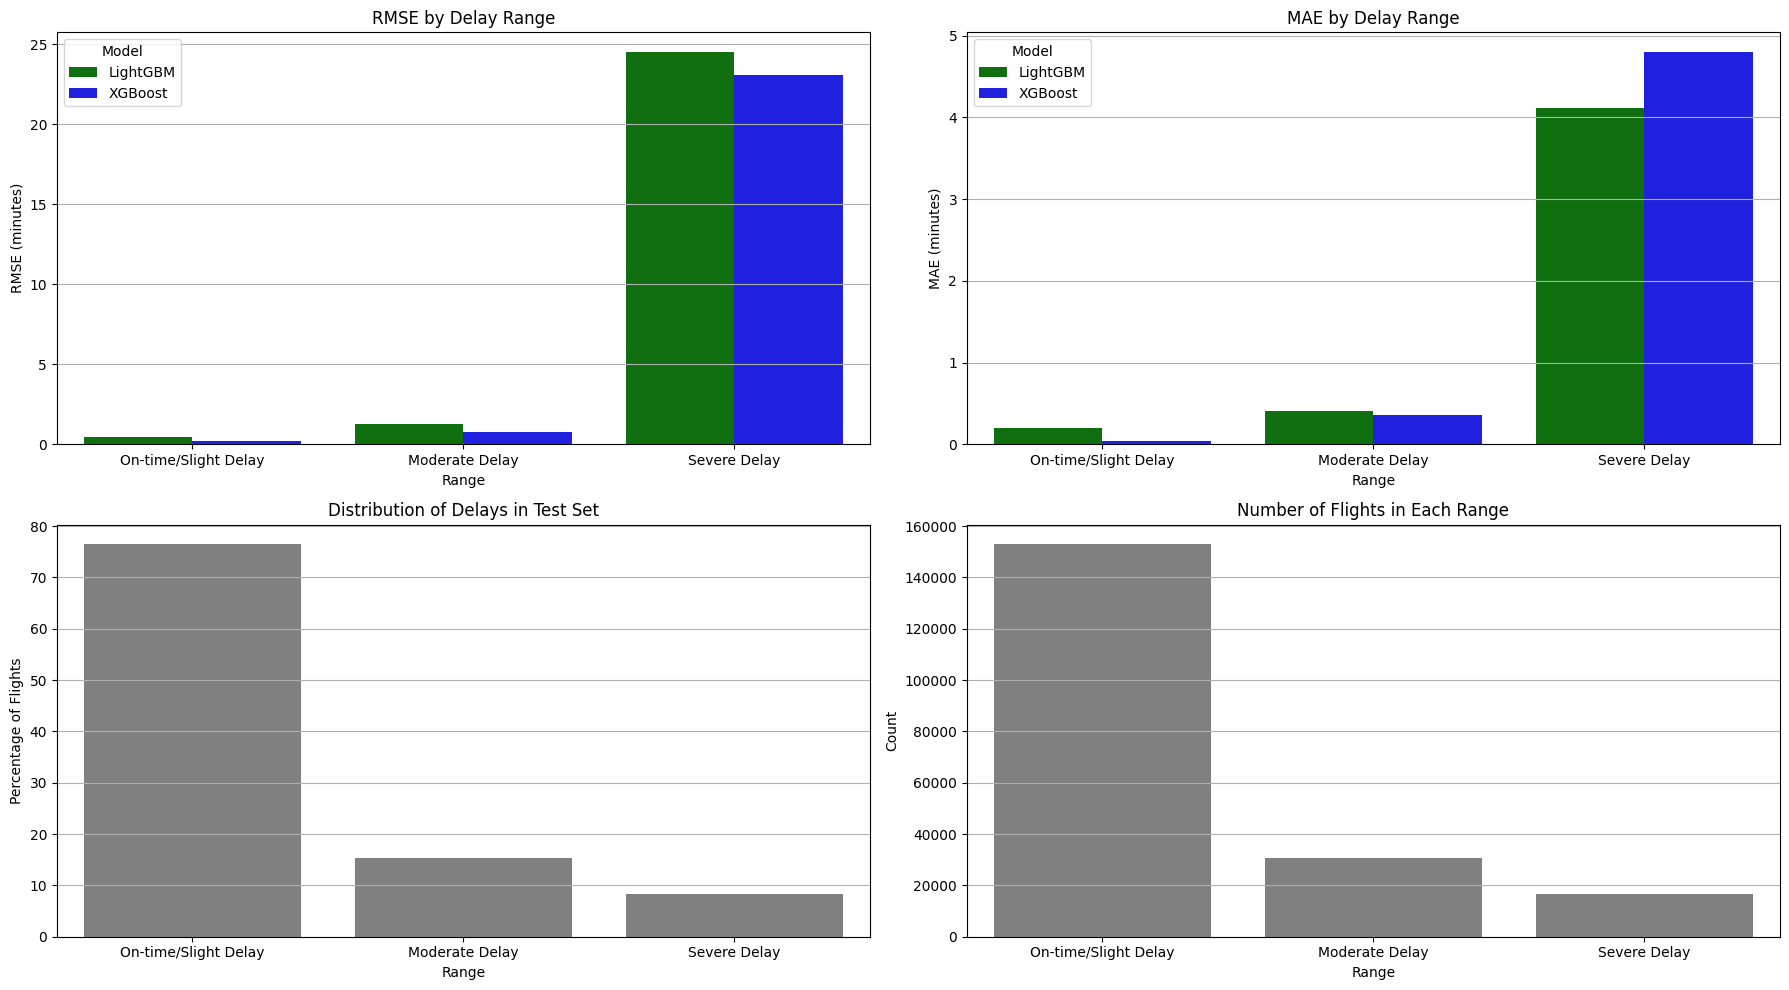

Detailed Performance Metrics by Delay Range:

                         RMSE              MAE        
Model                LightGBM XGBoost LightGBM XGBoost
Range                                                 
Moderate Delay           1.26    0.77     0.40    0.36
On-time/Slight Delay     0.43    0.19     0.20    0.03
Severe Delay            24.51   23.09     4.12    4.80


In [24]:
# 5. Additional performance visualizations

# Prediction vs Actual by delay range
plt.figure(figsize=(18, 10))

# Define delay ranges for analysis
delay_ranges = [
    (-30, 0, 'Early'),
    (0, 15, 'On-time/Slight Delay'),
    (15, 60, 'Moderate Delay'),
    (60, float('inf'), 'Severe Delay')
]

# Create a function to calculate performance in each range
def analyze_by_range(y_true, y_pred, ranges):
    results = []
    
    for start, end, label in ranges:
        mask = (y_true >= start) & (y_true < end)
        if mask.sum() > 0:
            range_rmse = np.sqrt(mean_squared_error(y_true[mask], y_pred[mask]))
            range_mae = mean_absolute_error(y_true[mask], y_pred[mask])
            sample_count = mask.sum()
            results.append({
                'Range': label,
                'RMSE': range_rmse,
                'MAE': range_mae,
                'Count': sample_count,
                'Percentage': sample_count / len(y_true) * 100
            })
    
    return pd.DataFrame(results)

# Analyze model performance by delay range
lgb_range = analyze_by_range(y_test, lgb_test_preds, delay_ranges)
xgb_range = analyze_by_range(y_test, xgb_test_preds, delay_ranges)

# Add model column
lgb_range['Model'] = 'LightGBM'
xgb_range['Model'] = 'XGBoost'

# Combine results
combined_range = pd.concat([lgb_range, xgb_range])

# Plot RMSE by delay range
plt.subplot(221)
sns.barplot(x='Range', y='RMSE', hue='Model', data=combined_range, palette=['green', 'blue'])
plt.title('RMSE by Delay Range')
plt.ylabel('RMSE (minutes)')
plt.legend(title='Model')
plt.grid(True, axis='y')

# Plot MAE by delay range
plt.subplot(222)
sns.barplot(x='Range', y='MAE', hue='Model', data=combined_range, palette=['green', 'blue'])
plt.title('MAE by Delay Range')
plt.ylabel('MAE (minutes)')
plt.legend(title='Model')
plt.grid(True, axis='y')

# Show distribution of actual delay ranges
plt.subplot(223)
sns.barplot(x='Range', y='Percentage', data=lgb_range, color='gray')
plt.title('Distribution of Delays in Test Set')
plt.ylabel('Percentage of Flights')
plt.grid(True, axis='y')

# Show sample counts
plt.subplot(224)
sns.barplot(x='Range', y='Count', data=lgb_range, color='gray')
plt.title('Number of Flights in Each Range')
plt.ylabel('Count')
plt.grid(True, axis='y')

plt.tight_layout()
plt.show()

# Print detailed metrics by range
print("Detailed Performance Metrics by Delay Range:\n")
detailed_metrics = combined_range.pivot(index='Range', columns='Model', values=['RMSE', 'MAE'])
print(detailed_metrics.round(2))